In [162]:
import numpy as np
import os
import sys
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline
import SimpleITK as sitk
from scipy.ndimage.measurements import label as CClabel
from copy import deepcopy

In [8]:
def load_sitk(sitk_path):
    return np.swapaxes(sitk.GetArrayFromImage(sitk.ReadImage(str(sitk_path))),0,2)
def save_sitk(img_data,save_path):
    sitk.WriteImage(sitk.GetImageFromArray(np.swapaxes(img_data,0,2)),str(save_path))

In [14]:
class MorphologyOps(object):
    """
    Class that performs the morphological operations needed to get notably
    connected component. To be used in the evaluation
    """

    def __init__(self, binary_img, neigh):
        assert len(binary_img.shape) == 3, 'currently supports 3d inputs only'
        self.binary_map = np.asarray(binary_img, dtype=np.int8)
        self.neigh = neigh

    def border_map(self):
        """
        Creates the border for a 3D image
        :return:
        """
        west = ndimage.shift(self.binary_map, [-1, 0, 0], order=0)
        east = ndimage.shift(self.binary_map, [1, 0, 0], order=0)
        north = ndimage.shift(self.binary_map, [0, 1, 0], order=0)
        south = ndimage.shift(self.binary_map, [0, -1, 0], order=0)
        top = ndimage.shift(self.binary_map, [0, 0, 1], order=0)
        bottom = ndimage.shift(self.binary_map, [0, 0, -1], order=0)
        cumulative = west + east + north + south + top + bottom
        border = ((cumulative < 6) * self.binary_map) == 1
        return border


    def foreground_component(self):
        return ndimage.label(self.binary_map)

In [15]:
def borders(seg, ref, neigh=8):
    """
    This function determines the points that lie on the border of the
    inferred and reference segmentations
    :param seg: numpy array with binary mask from inferred segmentation
    :param ref: numpy array with binary mask from reference segmentation
    :param neigh: connectivity 4 or 8
    :return: numpy arrays of reference and inferred segmentation borders
    """
    border_ref = MorphologyOps(ref, neigh).border_map()
    border_seg = MorphologyOps(seg, neigh).border_map()
    return border_ref, border_seg

In [16]:
def border_distance(seg, ref, neigh=8):
    """
    This functions determines the distance at each seg border point to the
    nearest ref border point and vice versa
    :param seg: numpy array with binary mask from inferred segmentation
    :param ref: numpy array with binary mask from reference segmentation
    :param neigh: connectivity 4 or 8
    :return: numpy arrays for distance_from_ref_border, distance_from
    seg_border
    """
    border_ref, border_seg = borders(seg, ref, neigh)
    distance_ref = ndimage.distance_transform_edt(1 - border_ref)
    distance_seg = ndimage.distance_transform_edt(1 - border_seg)
    distance_border_seg = border_ref * distance_seg
    distance_border_ref = border_seg * distance_ref
    return distance_border_ref, distance_border_seg

In [17]:
def hausdorff_distance(seg, ref):
    ref_border_dist, seg_border_dist = border_distance(seg, ref, 8)
    return np.max([np.max(ref_border_dist), np.max(seg_border_dist)])

In [18]:
def hausdorff95_distance(seg, ref):
    ref_border_dist, seg_border_dist = border_distance(seg, ref, 8)
    border_ref, border_seg = borders(seg, ref, 8)
    seg_values = ref_border_dist[border_seg > 0]
    ref_values = seg_border_dist[border_ref > 0]
    if seg_values.size == 0 or ref_values.size == 0:
        return np.nan
    return np.max([np.percentile(seg_values, 95),
                   np.percentile(ref_values, 95)])

In [19]:
def average_distance(seg, ref):
    ref_border_dist, seg_border_dist = border_distance(seg, ref, 8)
    border_ref, border_seg = borders(seg, ref, 8)
    return (np.sum(ref_border_dist) + np.sum(
        seg_border_dist)) / (np.sum(border_ref + border_seg))

In [20]:
def metric_all_labels(seg,ref,metric,labels=[0,1,2,3]):
    ret = []
    for l in labels:
        _s = seg==l
        _r = ref==l
        ret += [metric(_s,_r),]
    ret = np.asarray(ret,dtype=float)
    return ret

In [21]:
def Dice(pred,true,labels=[0,1,2,3]):
    l = len(labels)
    ret = np.zeros(l)
    for i in range(l):
        lab = labels[i]
        p = pred==lab
        t = true==lab
        ret[i] = 2*float(np.logical_and(p,t).sum())/(p.sum()+t.sum())
    return ret

In [22]:
def Jaccard(pred,true,labels=[0,1,2,3]):
    l = len(labels)
    ret = np.zeros(l)
    for i in range(l):
        lab = labels[i]
        p = pred==lab
        t = true==lab
        ret[i] = float(np.logical_and(p,t).sum())/float(np.logical_or(p,t).sum())
    return ret

In [23]:
data_dir = '/proj/NIRAL/users/siyangj/NewModels/model_0405_report/models/1/real_ensemble/'

In [24]:
true_path = '/proj/NIRAL/users/siyangj/myData/min_normal/seg_inf_1/1.nrrd'

In [25]:
true_im = load_sitk(true_path)

In [27]:
im_size = (96,112,96)
output_image = np.zeros(im_size + (4,))
for b in ['660','best','700']:
    _path = os.path.join(data_dir,'batch_'+b,'prediction-1.nrrd')
    _im = load_sitk(_path)
    print(Dice(_im,true_im))
    for _l in range(4):
        output_image[:,:,:,_l] += (_im==_l).astype(int)
output_image = np.argmax(output_image,axis=-1)

[0.99460224 0.84364008 0.85687191 0.84297605]
[0.99468602 0.8447206  0.8585825  0.84390267]
[0.99467369 0.84357003 0.85735881 0.84576104]


In [28]:
Dice(output_image,true_im)

array([0.99464654, 0.84505406, 0.85852027, 0.84572469])

In [29]:
metric_all_labels(output_image,true_im,hausdorff_distance)

array([37.33630941, 11.        ,  8.30662386,  9.        ])

In [30]:
metric_all_labels(output_image,true_im,hausdorff95_distance)

array([1.        , 2.23606798, 1.41421356, 1.41421356])

In [31]:
metric_all_labels(output_image,true_im,average_distance)

array([0.5026898 , 0.70157565, 0.6214392 , 0.53821379])

In [34]:
Jaccard(output_image,true_im)

array([0.98935009, 0.73168278, 0.7521117 , 0.73268889])

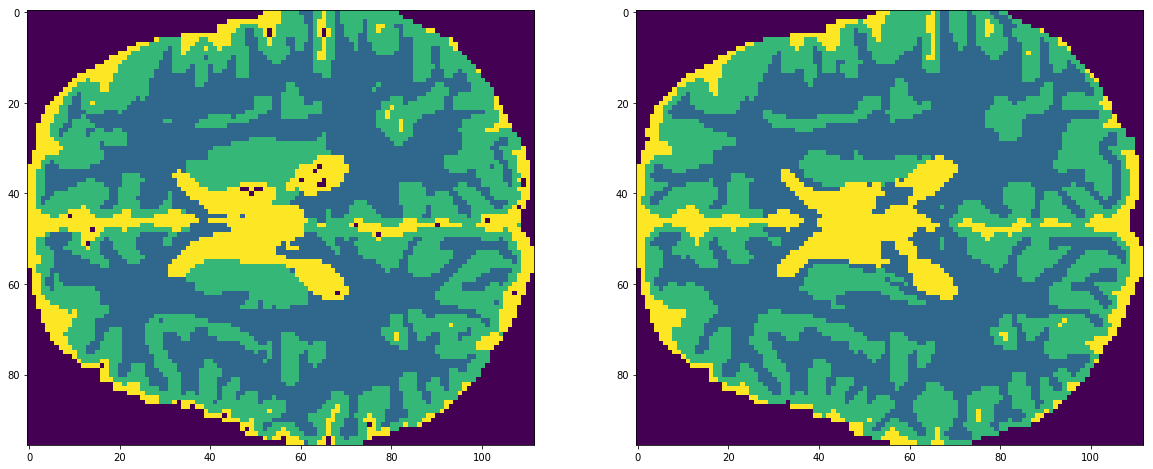

In [35]:
f,axes = plt.subplots(1,2,figsize=(20,20))
axes[0].imshow(output_image[:,:,60])
axes[1].imshow(true_im[:,:,60])


In [40]:
def clean_one_image(arr_original,arr_true):
    arr = deepcopy(arr_original)
    original_dice = Dice(arr,arr_true)
    
    for _l in [0,1,2,3]:
        carr = deepcopy(arr)
        carr[carr!=_l]=0
        labeled, ncomponents = CClabel(carr)
        ls,cs = np.unique(labeled,return_counts=True)
        ls = ls[np.argsort(cs)[:-3]]
        
        for _i in ls:
            arr[labeled==_i]=0
    
    new_dice = Dice(arr,arr_true)
    
    return arr,original_dice,new_dice

In [190]:
_lab = 3
s = (output_image==_lab).astype(int)
r = (true_im==_lab).astype(int)

In [180]:
structure = np.ones([3,3,3])
labeleds, ncomponentss = CClabel(s,structure=structure)
labeledr, ncomponentsr = CClabel(r,structure=structure)

ls,cs = np.unique(labeleds,return_counts=True)
lr,cr = np.unique(labeledr,return_counts=True)


In [212]:
seg_small = np.logical_and(labeleds!=0,labeleds!=1)
ref_small = np.logical_and(labeledr!=0,labeledr!=1)

In [214]:
seg_small.sum(),ref_small.sum()

(992, 1979)

In [215]:
both_small = np.logical_and(seg_small,ref_small)

In [217]:
both_small.sum()

509

In [219]:
labeledb, ncomponentsb = CClabel(both_small,structure=structure)
lb,cb = np.unique(labeledb,return_counts=True)

In [220]:
cb

array([1031683,      42,       2,       1,       2,       1,       1,
             6,       3,      13,       4,       1,       3,       9,
            24,       6,       1,       2,       3,      10,       4,
             4,       1,       7,       7,       6,       1,       1,
             1,       2,      10,       1,       2,       6,       1,
             1,       1,       4,       1,       3,       2,       1,
             1,       2,       1,       2,       3,       2,       4,
             1,       1,       3,       1,      10,       9,       2,
             2,       1,       1,       1,       1,       8,       2,
             3,       1,      12,       2,       1,       1,       2,
             9,       1,       7,       1,       1,       2,       8,
             5,       2,       1,       1,       9,       2,       3,
             8,       5,       4,       2,       1,       7,       1,
             3,       2,       4,       3,       5,       5,       5,
             1,     

In [181]:
s_im = sitk.GetImageFromArray(np.swapaxes(s,0,2))

In [182]:
vectorRadius = (1, 1, 1)
kernel = sitk.sitkBall

seg_clean = sitk.BinaryMorphologicalClosing(s_im,
                                            vectorRadius,
                                            kernel)
seg_clean2 = sitk.BinaryMorphologicalOpening(seg_clean,
                                            vectorRadius,
                                            kernel)

In [183]:
s2 = np.swapaxes(sitk.GetArrayFromImage(seg_clean),0,2)
s3 = np.swapaxes(sitk.GetArrayFromImage(seg_clean2),0,2)

In [184]:
allowed_new = np.logical_and(np.logical_and(s2==1,s==0),output_image==0)

In [185]:
np.where(allowed_new)[0].shape

(4279,)

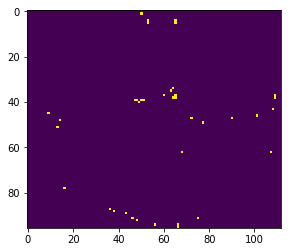

In [186]:
plt.imshow(allowed_new[:,:,60])

In [192]:
new_output = deepcopy(output_image)

In [193]:
new_output[allowed_new] = _lab

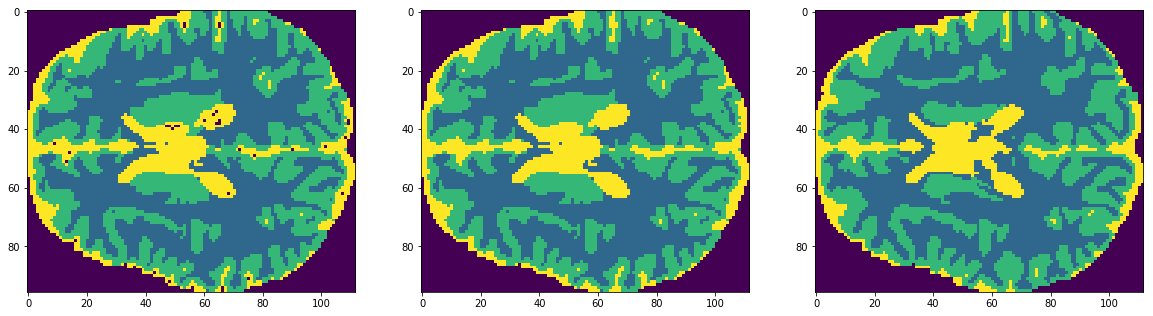

In [194]:
f,axes = plt.subplots(1,3,figsize=(20,30))
axes[0].imshow(output_image[:,:,60])
axes[1].imshow(new_output[:,:,60])
axes[2].imshow(true_im[:,:,60])

In [195]:
Dice(output_image,true_im)

array([0.99464654, 0.84505406, 0.85852027, 0.84572469])

In [196]:
Dice(new_output,true_im)

array([0.9967594 , 0.84505406, 0.85852027, 0.8579236 ])

In [197]:
new_output[true_im==0]=0

In [198]:
Dice(new_output,true_im)

array([0.99898874, 0.84505406, 0.85855975, 0.86648237])

In [199]:
should_be_zero = np.logical_and(output_image!=0,true_im==0)

In [203]:
np.where(should_be_zero)[0].shape

(1089,)

In [205]:
np.unique(output_image[should_be_zero],return_counts=True)

(array([2, 3]), array([  24, 1065]))

In [207]:
should_not_be_zero = np.logical_and(output_image==0,true_im!=0)
np.unique(true_im[should_not_be_zero],return_counts=True)

(array([1, 2, 3], dtype=int16), array([  10,  360, 3809]))

In [208]:
metric_all_labels(new_output,true_im,hausdorff95_distance)

array([0.        , 2.23606798, 1.41421356, 1.        ])

In [209]:
metric_all_labels(new_output,true_im,hausdorff_distance)

array([30.3644529 , 11.        ,  8.30662386,  9.        ])

In [210]:
metric_all_labels(new_output,true_im,average_distance)

array([0.03532207, 0.70157565, 0.62128395, 0.50468984])

In [229]:
_im = 7

t2dir = '/proj/NIRAL/users/siyangj/myData/min_normal/seg_inf_1/%d.nrrd'%_im
t2 = load_sitk(t2dir)

_lab = 3
r2 = (t2==_lab).astype(int)

structure = np.ones([3,3,3])
labeledr2, ncomponentsr2 = CClabel(r,structure=structure)

lr2,cr2 = np.unique(labeledr2,return_counts=True)

(array([234., 113.,  21.,   3.,   0.,   0.,   0.,   0.,   1.,   1.]),
 array([ 0.        ,  1.37425021,  2.74850043,  4.12275064,  5.49700085,
         6.87125107,  8.24550128,  9.61975149, 10.99400171, 12.36825192,
        13.74250213]),
 <a list of 10 Patch objects>)

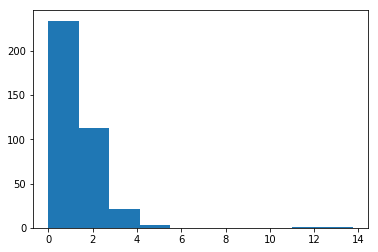

In [230]:
plt.hist(np.log(cr2))